# MDAnalysis

In [1]:
import MDAnalysis as mda
import nglview as nv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import scipy.spatial.distance as ssd
from scipy import constants
from scipy.linalg import eig, inv
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.neighbors import KernelDensity

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout as layout

import seaborn as sns

import time
import random

In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 14})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

In [3]:
print(mda.__version__)
print(nv.__version__)
print(nx.__version__)

2.1.0
3.0.3
2.4


### Functions

In [4]:
def minimum_image(point,cell):
    
    rc = 1.0/cell
    point = point - cell*np.rint(rc*point)
    return(point)

In [5]:
def centre_of_mass(positions,masses):
    com = np.zeros(3)    
    for i in range(0,len(positions)):
        com += positions[i]*masses[i]
        
    return(com/np.sum(masses))

In [6]:
def calculate_gyration_tensor(positions):
    gyration_tensor = np.zeros((3, 3))
    for i in range(0,len(positions)):
        gyration_tensor += np.outer(positions[i], positions[i])
    return gyration_tensor / len(positions)

### Load the LAMMPS files

In [7]:
LAMMPSDATA = 'lmp.data'
u = mda.Universe(LAMMPSDATA, atom_style="id resid type charge x y z")
#traj_list = ['trajectory.0.xtc', 'trajectory.1.xtc', 'trajectory.2.xtc', 'trajectory.3.xtc', 'trajectory.4.xtc', 'trajectory.5.xtc', 'trajectory.6.xtc', 'trajectory.7.xtc', 'trajectory.8.xtc', 'trajectory.9.xtc', 'trajectory.10.xtc', 'trajectory.11.xtc', 'trajectory.12.xtc', 'trajectory.13.xtc', 'trajectory.14.xtc', 'trajectory.15.xtc', 'trajectory.16.xtc']
traj_list = ['trajectory.39.xtc']
%time u.load_new(traj_list)
#%time u.load_new('trajectory.16.xtc')
print(u.trajectory)

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 1
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 2
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 3
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 4
  warnings.warn("Failed to guess the mass for the f

CPU times: user 9.41 ms, sys: 955 µs, total: 10.4 ms
Wall time: 10.4 ms
<XTCReader trajectory.39.xtc with 8213 frames of 91500 atoms>


In [8]:
u.trajectory

<XTCReader trajectory.39.xtc with 8213 frames of 91500 atoms>

### Select the atoms of interest

In [9]:
calcium = u.select_atoms('type 1')
carbon = u.select_atoms('type 2')
ionclusters = u.select_atoms('type 1 2')
carbonate = u.select_atoms('type 2 4')
wateroxygen = u.select_atoms('type 5')
water = u.select_atoms('type 3 5')

### Set the atom charges and masses

In [10]:
# Atomic masses
mca = 40.078
mc = 12.0107
mo = 15.9994
mh = 1.0079

calcium.masses = mca
carbon.masses = mc
carbonate.masses = mc + 3*mo
wateroxygen.masses = mo
water.masses = mo + 2*mh

# Gale force field charges
qca = 2.0000
qc4 = 1.123285
qo4 = -1.041095
qo2 = -0.820000
qh2 = 0.410000

calcium.charges = qca
carbon.charges = qc4
carbonate.charges = qc4 + 3*qo4
wateroxygen.charges = qo2
water.charges = qo2 + 2*qh2

### Loop through the frames and identify the droplet (largest cluster)

In [11]:
from MDAnalysis.analysis.distances import contact_matrix
import MDAnalysis.transformations as trans

# Set the cutoff for first sphere coordination
trunc_distance = 4.0#irdf.bins[truncation] 

# Density profile arrays
delta = 1
maxd = u.dimensions[0]*2
nbins = np.int(maxd/delta)
rad_dist_calc = np.zeros(nbins)
rad_dist_carb = np.zeros(nbins)
rad_dist_wats = np.zeros(nbins)

# Scaling factors
molarity_scaling = 1e+27/constants.Avogadro
molal_scaling = 1/((len(wateroxygen)*water.masses[0]/1000))

# Plotting arrays
time = [] # simulation time
ncls = [] # number of clusters
clsz = [] # cluster sizes
dsiz = [] # droplet size
dchg = [] # droplet charge
drgy = [] # droplet radius of gyration
dasp = [] # droplet asphericity
ccat = [] # cation concentration
cani = [] # anion concentration
cdim = [] # dimer concentration
ctet = [] # tetramer concentration
chex = [] # hexamer concentration
bcat = [] # cation molality
bani = [] # anion molality

# Volume
cvol = []

# Droplet content
drop_calc = []
drop_carb = []

frames = 0

# Loop through the frames
for ts in u.trajectory[0:-1:200]:
    
    if ts.frame%10 == 0:
        print(ts)
    
    # Cell dimensions
    cell = ts.dimensions[0:3]
    cvol.append(cell[0]**3)    

    #============== IDENTIFY ALL OF THE CLUSTERS ===============
    
    # Generate the adjacancy matrix
    adjmatrix = contact_matrix(ionclusters.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)

    # Generate a graph from the adjacency matrix
    Graph = nx.Graph(adjmatrix)
    
    # Size of connected components in the graph
    cluster_size = [len(c) for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    largest_cluster_size = cluster_size[0]

    # Number of connected components
    number_of_clusters = len(cluster_size)    
    
    # List of nodes in every connected component
    cluster_members = [c for c in sorted(nx.connected_components(Graph), key=len, reverse=True)]
    
    #============== ANALYSE THE LARGEST CLUSTER ===============
    
    # Get the components of the largest cluster
    largest_cluster_indices = list(cluster_members[0])
    droplet = u.atoms[(ionclusters.indices[largest_cluster_indices])]
    
    # Build a new graph
    adjmatrix_droplet = contact_matrix(droplet.positions, cutoff=trunc_distance, returntype='numpy', box=ts.dimensions)
    Graph_droplet = nx.Graph(adjmatrix_droplet)     
    
    # Depth first search for connected nodes
    T = nx.dfs_tree(Graph_droplet, source=0)
    E = list(T.edges())
        
    # Reconstruct the droplet across boundaries
    pos = droplet.positions
    for i in range(0,len(E)):   
        v = pos[E[i][1]] - pos[E[i][0]]
        pos[E[i][1]] = pos[E[i][0]] + minimum_image(v,cell)            
    
    # Droplet centre of mass
    com = centre_of_mass(pos,droplet.masses)
    
    # Calculate the gyration tensor
    gyration_tensor = calculate_gyration_tensor(pos - com)

    eVals,eVecs = eig(gyration_tensor)    # Diagonalise
    eVals = eVals.real
    eVals = np.sort(eVals)

    droplet_rgyr = np.sum(eVals)**0.5                                 # Radius of gyration
    droplet_asph = 3/2*eVals[2] - droplet_rgyr**2/2                   # Asphericity
    #droplet_acyl = eVals[1] - eVals[0]                                # Acylindricity
    #droplet_kapa = 3/2 * (np.sum(eVals**2)/np.sum(eVals)**2) - 0.5    # Relative shape anisotropy
    
    # Droplet charge
    droplet_charge = droplet.total_charge()  
    
    # Droplet Ca density profiles
    natms = np.sum(droplet.types == '1' )
    drop_calc.append(natms)
    parr = pos[droplet.types == '1']
    for i in range(0,natms):
        v = parr[i] - com
        d = np.sqrt(np.dot(v,v))/delta
        rad_dist_calc[d.astype(int)] +=1
        
    # Droplet C density profiles
    natms = np.sum(droplet.types == '2' )
    drop_carb.append(natms)
    parr = pos[droplet.types == '2']
    for i in range(0,natms):
        v = parr[i] - com
        d = np.sqrt(np.dot(v,v))/delta
        rad_dist_carb[d.astype(int)] +=1
        
    # Droplet water density profiles
    #wcutoff = maxd/2
    #wsel = 'type 5 and point ' + str(com[0])+' '+str(com[1])+' '+str(com[2])+' '+wcutoff.astype(str)
    #radwats = u.select_atoms(wsel,updating=True)
    
    for i in range(0,wateroxygen.n_atoms):        
        v = wateroxygen.positions[i] - com
        v = com + minimum_image(v,cell)
        
        d = np.sqrt(np.dot(v,v))/delta
        rad_dist_wats[d.astype(int)] +=1
    
    
    #============== ANALYSE THE SOLUTION ===============
    
    # Get the dispersed ions
    monomer_charges = [] 
    monomer_indices = np.argwhere(np.array(cluster_size) == 1)
    
    for i in range(0,monomer_indices.size):      
        at = list(cluster_members[np.int(monomer_indices[i])]) # ion index

        monomer_charges.append(u.atoms[at].charges)
        
        
    # Count the number of positive and negative ions
    number_cations = np.sum(np.array(monomer_charges) > 0)
    number_anions = np.sum(np.array(monomer_charges) < 0)
    concn_cations = number_cations/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    concn_anions = number_anions/ts.dimensions[0]**3*molarity_scaling*1000 #mM
    molal_cations = number_cations*molal_scaling*1000 #mmol
    molal_anions = number_anions*molal_scaling*1000 #mmol
    
    
    # Count the number of small associates
    dims = np.sum(np.array(cluster_size) == 2)
    tets = np.sum(np.array(cluster_size) == 4)
    hexs = np.sum(np.array(cluster_size) == 6)
    cdim.append(dims/ts.dimensions[0]**3*molarity_scaling)
    ctet.append(tets/ts.dimensions[0]**3*molarity_scaling)
    chex.append(hexs/ts.dimensions[0]**3*molarity_scaling)
    
    # Report the time series cluster information
    #print(ts.time,number_of_clusters,largest_cluster_size, droplet_charge, 
    #      droplet_rgyr, number_cations, number_anions, molal_cations,
    #     molal_anions)    

    
    # Record the data for plotting
    time.append(ts.time/1000)
    ncls.append(number_of_clusters)
    clsz.extend(cluster_size[:])
    dsiz.append(largest_cluster_size)
    dchg.append(droplet_charge)
    drgy.append(droplet_rgyr/10)
    dasp.append(droplet_asph)
    ccat.append(concn_cations)
    cani.append(concn_anions)
    bcat.append(molal_cations)
    bani.append(molal_anions)
    
    
    frames += 1

< Timestep 0 with unit cell dimensions [96.153656 96.153656 96.153656 90.       90.       90.      ] >
< Timestep 200 with unit cell dimensions [96.10629 96.10629 96.10629 90.      90.      90.     ] >
< Timestep 400 with unit cell dimensions [96.15054 96.15054 96.15054 90.      90.      90.     ] >
< Timestep 600 with unit cell dimensions [96.110214 96.110214 96.110214 90.       90.       90.      ] >
< Timestep 800 with unit cell dimensions [96.04631 96.04631 96.04631 90.      90.      90.     ] >
< Timestep 1000 with unit cell dimensions [96.09913 96.09913 96.09913 90.      90.      90.     ] >
< Timestep 1200 with unit cell dimensions [96.01597 96.01597 96.01597 90.      90.      90.     ] >
< Timestep 1400 with unit cell dimensions [96.10825 96.10825 96.10825 90.      90.      90.     ] >
< Timestep 1600 with unit cell dimensions [96.12351 96.12351 96.12351 90.      90.      90.     ] >
< Timestep 1800 with unit cell dimensions [96.11256 96.11256 96.11256 90.      90.      90.    

In [12]:
binp = np.arange(0,nbins)*delta

#rad_calc /= frames
dV = 4/3*constants.pi * ((binp+delta)**3-binp**3)
rad_calc = (rad_dist_calc / frames) / dV * 1E27/constants.Avogadro
rad_carb = (rad_dist_carb / frames) / dV * 1E27/constants.Avogadro
rad_ions = (rad_calc+rad_carb)/2
rad_wats = (rad_dist_wats / frames) / dV * 1E27/constants.Avogadro

/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/aaron/Packages/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


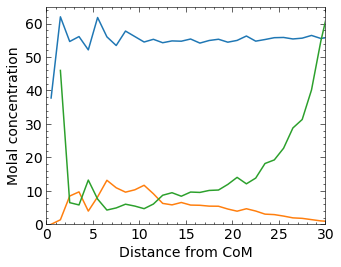

In [13]:
binp = binp + delta/2
plt.xlim(0,30)
plt.ylim(0,65)
plt.plot(binp,rad_wats,'-')
plt.plot(binp,rad_ions,'-')
plt.xlabel("Distance from CoM")
plt.ylabel("Molal concentration")
plt.plot(binp,rad_wats/rad_ions,'-')
plt.savefig('density-profiles.png',dpi=100)
np.savetxt('rad_dens_calc.dat',np.column_stack([binp,rad_calc]))
np.savetxt('rad_dens_carb.dat',np.column_stack([binp,rad_carb]))
np.savetxt('rad_dens_ions.dat',np.column_stack([binp,rad_ions]))
watperfu = np.nan_to_num(rad_wats/rad_ions, nan=0, posinf=0, neginf=0)
np.savetxt('rad_dens_watperfu.dat',np.column_stack([binp,watperfu]))

### Plot the cluster size distribution

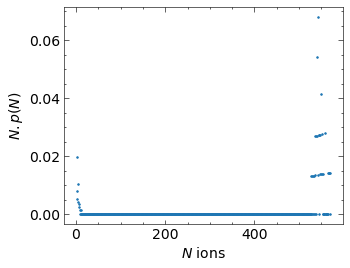

In [14]:
clsz = np.array(clsz)
histmin = np.amin(clsz)
histmax = np.amax(clsz)
xaxis = np.arange(1,histmax+1)
bins = xaxis.size

hist, bin_edges = np.histogram(clsz, density=True, bins=bins)
plt.ylabel("$N.p(N)$")
plt.xlabel("$N$ ions")
plt.yscale=('log')
plt.plot(xaxis,(hist/frames)*xaxis,'.',markersize=pms)
plt.savefig('csd.png',dpi=100)

### Ks from concentrations

In [15]:
catcon = np.mean(ccat)/1000
cancon = np.mean(cani)/1000
dimcon = np.mean(cdim)
tetcon = np.mean(ctet)
hexcon = np.mean(chex)

print("mM cation, anion, dimer, tetramer, hexamer concentrations")
print(catcon*1000,cancon*1000,dimcon*1000,tetcon*1000,hexcon*1000)

mM cation, anion, dimer, tetramer, hexamer concentrations
1.2017973453962045 8.501283792254286 17.583094847041256 4.583823155279415 0.8012556898490577


In [16]:
K1 = dimcon/(catcon*cancon)
print('K1',K1)
K2 = tetcon/dimcon**2
print('K2',K2)
K3 = hexcon/dimcon**3
print('K3',K3)
print("FE equivalents")
print(-2.479*np.log(K1),-2.479*np.log(K2),-2.479*np.log(K3))

K1 1720.9948243273643
K2 14.82645133900348
K3 147.39582089607467
FE equivalents
-18.470180658543004 -6.684407425823161 -12.377948513887196


### Plots

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


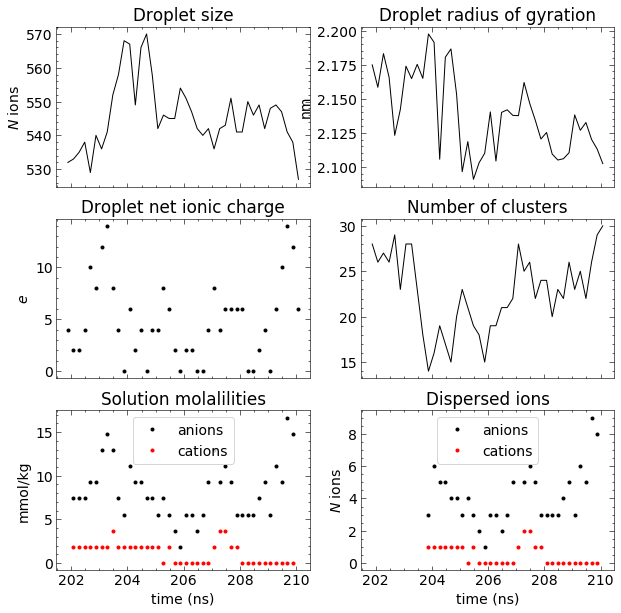

In [17]:
fig, [[ax0, ax1], [ax2, ax3], [ax4, ax5]] = plt.subplots(nrows=3, ncols=2, sharex=True,figsize=(10,10))  

# Droplet size
#ax0.set_xlim([intzmin+1.5,intzmax-0.1])
#ax0.set_ylim([0,2.5])
ax0.title.set_text('Droplet size')
ax0.set_ylabel("$N$ ions")
ax0.plot(time,dsiz,'k-',linewidth=1)

# Radius of gyration
#ax1.set_xlim([intzmin,intzmax-0.1])
#ax1.set_ylim([0,1.05])
ax1.title.set_text('Droplet radius of gyration')
ax1.set_ylabel("nm")
ax1.plot(time,drgy,'k-',linewidth=1)

# Droplet net ionic charge
#ax2.set_xlim([intzmin,intzmax-0.1])
#ax2.set_ylim([-1,1])
ax2.title.set_text('Droplet net ionic charge')
ax2.set_ylabel("$e$")
ax2.plot(time,dchg,'ko',markersize=pms)

# Number of clusters
#ax3.set_xlim([intzmin,intzmax-0.1])
#ax3.set_ylim([0,2.5])
ax3.title.set_text('Number of clusters')
ax3.set_ylabel("")
ax3.plot(time,ncls,'k-',linewidth=1)

# Free ion molalities
#ax4.set_xlim([intzmin,intzmax-0.1])
#ax4.set_ylim([0,2.5])
ax4.title.set_text('Solution molalilities')
ax4.set_ylabel("mmol/kg")
ax4.plot(time[1:-1],bani[1:-1],'ko',markersize=pms, label='anions')
ax4.plot(time[1:-1],bcat[1:-1],'ro',markersize=pms, label='cations')
legend = ax4.legend(loc='upper center')
ax4.set_xlabel("time (ns)")

# Free ion molalities
#ax4.set_xlim([intzmin,intzmax-0.1])
#ax4.set_ylim([0,2.5])
ax5.title.set_text('Dispersed ions')
ax5.set_ylabel("$N$ ions")
ax5.plot(time[10:-1],np.array(bani[10:-1])/(molal_scaling*1000),'ko',markersize=pms, label='anions')
ax5.plot(time[10:-1],np.array(bcat[10:-1])/(molal_scaling*1000),'ro',markersize=pms, label='cations')
legend = ax5.legend(loc='upper center')
ax5.set_xlabel("time (ns)")

plt.savefig('timeseries.png',dpi=100)

### Averages

In [18]:
print("Mean volume")
meanV = np.mean(cvol)
print(meanV,np.std(cvol))

Mean volume
888305.5038966446 1142.0195837487288


In [19]:
print("Mean anion molality and number w/ errors")
print(np.mean(cani),np.std(cani),np.mean(bani)/(molal_scaling*1000),np.std(bani)/(molal_scaling*1000))

Mean anion molality and number w/ errors
8.501283792254286 3.294213318968799 4.5476190476190474 1.7620656297217512


In [20]:
print("Mean cation molality and number w/ errors")
print(np.mean(ccat),np.std(ccat),np.mean(bcat)/(molal_scaling*1000),np.std(bcat)/(molal_scaling*1000))

Mean cation molality and number w/ errors
1.2017973453962045 1.2115004027491356 0.6428571428571428 0.6481265518483905


In [21]:
print("Mean droplet size w/ error: total; Ca; C")
print(np.mean(dsiz),np.std(dsiz))
print(np.mean(drop_calc),np.std(drop_calc))
print(np.mean(drop_carb),np.std(drop_carb))

Mean droplet size w/ error: total; Ca; C
545.6428571428571 9.891847120522147
274.0238095238095 4.703028888453013
271.6190476190476 5.353914371090607


In [22]:
print("Mean ions not in the droplet w/ error: Ca; C")
calc_lean = calcium.n_atoms-np.mean(drop_calc)
carb_lean = carbon.n_atoms-np.mean(drop_carb)
print(calc_lean,np.std(drop_calc))
print(carb_lean,np.std(drop_carb))
scaling = 1/meanV*molarity_scaling*1000
print(calc_lean*scaling,np.std(drop_calc)*scaling)
print(carb_lean*scaling,np.std(drop_carb)*scaling)

Mean ions not in the droplet w/ error: Ca; C
25.97619047619048 4.703028888453013
28.380952380952408 5.353914371090607
48.558158103095856 8.791528555284142
53.05345963234675 10.008250468449033


In [23]:
print("Mean Rgyr w/ error (nm)")
print(np.mean(drgy),np.std(drgy))
print("Mean Asphericity w/ error")
print(np.mean(dasp),np.std(dasp))

Mean Rgyr w/ error (nm)
2.1384113076068303 0.02904610598709838
Mean Asphericity w/ error
221.20890119121563 15.586504080252107


In [24]:
print("Mean droplet charge w/ error")
print(np.mean(dchg),np.std(dchg))

Mean droplet charge w/ error
4.809523809523809 3.855966898927373


In [25]:
print("Mean Ca, C and Ow concentration in droplet core")
print(np.mean(rad_calc[binp<np.mean(drgy)*10]),np.std(rad_calc[binp<np.mean(drgy)*10]))
print(np.mean(rad_carb[binp<np.mean(drgy)*10]),np.std(rad_carb[binp<np.mean(drgy)*10]))
print(np.mean(rad_wats[binp<np.mean(drgy)*10]),np.std(rad_wats[binp<np.mean(drgy)*10]))

Mean Ca, C and Ow concentration in droplet core
6.776357545593227 3.731630615929039
7.103188130887416 3.556572321741132
54.79825725086076 4.4539132991807495


In [26]:
print("Mean water per fu")
print(np.mean(watperfu[binp<np.mean(drgy)*10]),np.std(watperfu[binp<np.mean(drgy)*10]))

Mean water per fu
9.636494770234963 8.740602503744118


In [27]:
print("Mean number of clusters")
print(np.mean(ncls),np.std(ncls))

Mean number of clusters
22.61904761904762 4.163059663232943


### Legacy

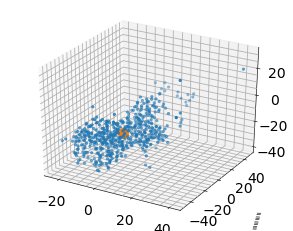

In [28]:
com = centre_of_mass(droplet.positions,droplet.masses)

xs = droplet.positions.T[:][0]
ys = droplet.positions.T[:][1]
zs = droplet.positions.T[:][2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs,s=5)
ax.scatter(com[0],com[1],com[2],s=100)